In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from utilities import plotting
from utilities import stats
from utilities import timestamps
from utilities import import_export
from utilities import polygon_selection
from mpl_toolkits.basemap import Basemap
from itertools import product
import matplotlib.pyplot as plt

kumamoto = {'coordinates':(130.763, 32.7545), 'time':'2016-04-14 12:26:00', 'tz':'UTC', 'magnitude':7.0}
eq = kumamoto

In [2]:
df = import_export.import_catalog(location='data/ccu.dat', delimiter='\t', names=['lon', 'lat', 'decimal_year', 'month', 'day', 'mag'
                                                        , 'depth', 'hour', 'minute', 'second', 'horizontal_error'
                                                        , 'depth_error', 'mag_err'])

df_regional = polygon_selection.get_node_data(data=df, node=eq['coordinates'], radius=200, m=1)
df_regional = df_regional.loc[df_regional.index < eq['time']]
df_regional = df_regional[df_regional.depth <=25]
df_regional = df_regional[df_regional.mag >= 0.5]

In [3]:
def calc_b_value_for_parameters(dataframe, parameters, location):
    # TODO: will multiprocessing speed this up?
    rows = []
    for r, t in parameters:
        try:
#             for r, t in parameters:
            df_c = polygon_selection.get_node_data(node=location, data=dataframe, radius=r, m=1)
            df_c = df_c.loc[df_c.index >= t]

            a, b, bstd, n, mc = stats.calc_fmd_stats_with_mc(df_c.mag)
            row = np.array((r,) + (t,) + (a, b, bstd, n, mc) + tuple(location))
            rows.append(row)
        except:
            row = np.array((r,) + (t,) +(np.nan, np.nan, np.nan, np.nan, np.nan) + tuple(location))

    return rows

def calc_b_for_parameters_attr_iter(attr):
    dataframe, parameters, location = attr
    return calc_b_value_for_parameters(dataframe, parameters, location)

In [4]:
radii = np.arange(5, 26, 1)
foreshock_time = eq['time']

timii = pd.date_range(start='01-01-1990 00:00:00', end=foreshock_time, freq='6M', tz='GMT')
parameters = [x for x in product(radii, timii)]

In [5]:
fmds = calc_b_value_for_parameters(df_regional, parameters, eq['coordinates'])

In [6]:
bdf = pd.DataFrame(fmds, columns=['radius', 'start_time', 'a', 'b', 'bstd', 'n', 'mc', 'lon', 'lat'])

In [7]:
bdf.ix[0]['start_time']

Timestamp('1990-01-31 00:00:00+0000', tz='GMT')

In [8]:
b = 0.724913
mags = df_regional[df_regional.distance <= 5].mag
mags[mags >= 0.8].shape
stats.calc_fmd_stats_with_mc(mags)

(3.2889517473691283,
 0.63940615622477082,
 0.022519493673734285,
 599,
 0.80000000000000004)

In [9]:
r, t, a,b, bs, n, mc, lo, la = bdf.ix[0]

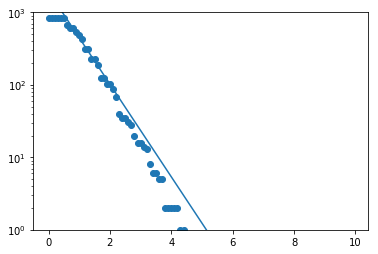

In [10]:
testdf = polygon_selection.get_node_data(node=eq['coordinates'], data=df_regional, radius=5, m=1)
testdf[testdf.mag >= 0.8].shape
testdf = testdf.loc[testdf.index >= bdf.ix[0]['start_time']]
mags = testdf.mag

h, e = np.histogram(a=mags, range=(0,10), bins=100)
chist = np.cumsum(h[::-1])[::-1]

plt.scatter(e[:-1], chist)
plt.yscale('log')
plt.ylim(1e0, 1e3)
x = np.arange(0,10,0.1)
y = 10**(a - b * x)
plt.plot(x, y)

(<matplotlib.figure.Figure at 0x7fa7e689d208>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7e6780e48>)

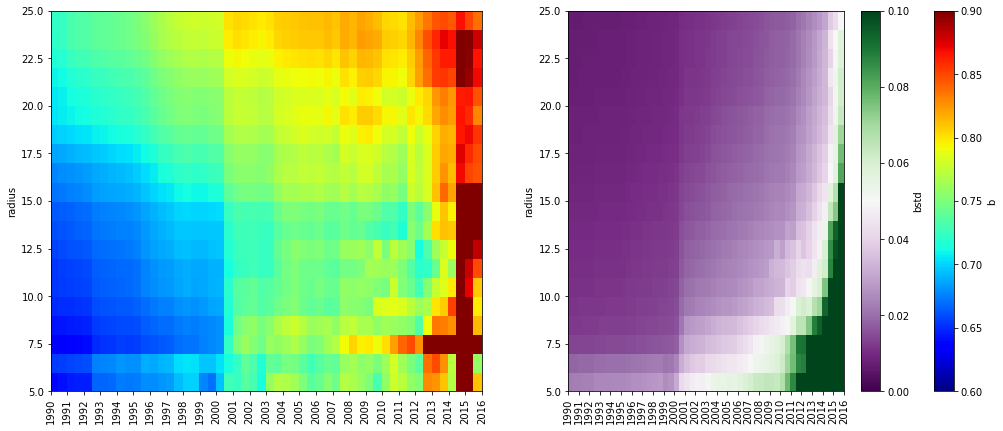

In [11]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(17, 7))
plotting.plot_radius_time_sweep(bdf, 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')
plotting.plot_radius_time_sweep(bdf, 'radius', 'bstd', fig, ax1, vmin=0.0, vmax=0.1, cmap='PRGn')

(<matplotlib.figure.Figure at 0x7fa7e68b31d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7e6656eb8>)

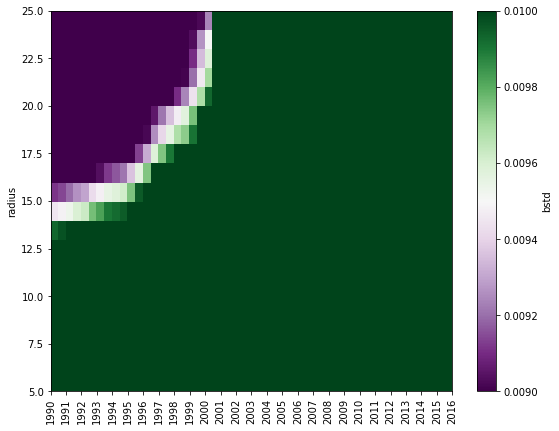

In [12]:
fig, ax = plt.subplots(figsize=(9, 7))
plotting.plot_radius_time_sweep(bdf, 'radius', 'bstd', fig, ax, vmin=0.009, vmax=0.01, cmap='PRGn')


In [13]:
bdf['errored'] = bdf.bstd.apply(lambda x : 1 if x < 0.01 else 0)

In [14]:
x = 0.025
bdf['b below x'] = bdf.apply(lambda row: row['b'] if row['bstd'] > x else np.nan, axis=1)

(<matplotlib.figure.Figure at 0x7fa7e682f358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7e689d6a0>)

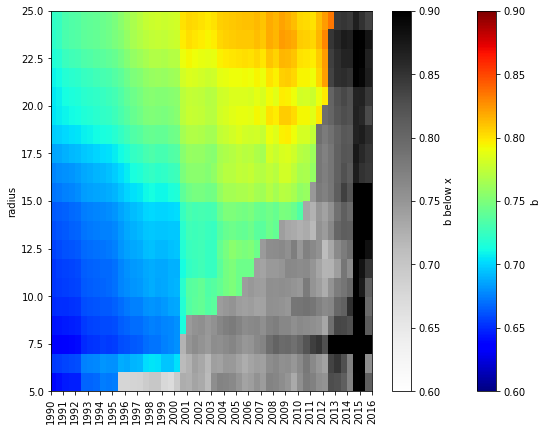

In [15]:
fig, ax = plt.subplots(figsize=(9, 7))
plotting.plot_radius_time_sweep(bdf, 'radius', 'b', fig, ax, vmin=0.6, vmax=0.9, cmap='jet')
plotting.plot_radius_time_sweep(bdf, 'radius', 'b below x', fig, ax, vmin=0.6, vmax=0.9, cmap='Greys')


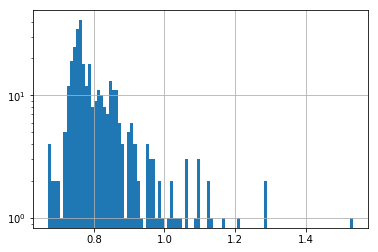

In [16]:
bdf['b below x'].hist(bins=100, log=True)

In [17]:
aftershocks = df[df.index > eq['time']]

(<mpl_toolkits.basemap.Basemap at 0x7fa7e60e88d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7e6211ba8>)

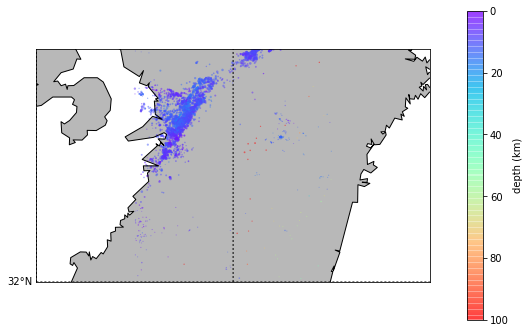

In [18]:
plotting.plot_seismicity_map(aftershocks[aftershocks.lon.between(130.5, 131.5) & aftershocks.lat.between(32, 33)])

In [19]:
np.sqrt(0.3**2 + 0.2**2)*111.119*1.6

64.10324034852529

In [20]:
z = lambda x : 1 if x > 0.01 else 0

In [21]:
bdf.describe()

,radius,a,b,bstd,n,mc,lon,lat,errored,b below x
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1.113000e+03,1.113000e+03,1113.000000,348.000000
mean,15.000000,3.625712,0.761027,0.031981,2463.215633,0.721833,1.307630e+02,3.275450e+01,0.194969,0.815475
std,6.058023,0.597863,0.080532,0.057322,2409.505985,0.043035,3.156228e-12,3.269966e-13,0.396355,0.104578
min,5.000000,1.154798,0.636206,0.006730,3.000000,0.700000,1.307630e+02,3.275450e+01,0.000000,0.670741
25%,10.000000,3.266445,0.714748,0.010965,510.000000,0.700000,1.307630e+02,3.275450e+01,0.000000,0.751795
50%,15.000000,3.757545,0.753071,0.016958,1683.000000,0.700000,1.307630e+02,3.275450e+01,0.000000,0.778449
75%,20.000000,4.076363,0.791094,0.030100,3632.000000,0.700000,1.307630e+02,3.275450e+01,0.000000,0.851346
max,25.000000,4.487911,1.532804,1.002907,9498.000000,1.000000,1.307630e+02,3.275450e+01,1.000000,1.532804
